In [1]:
import math
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt

In [2]:
#Função Sphere
def sphere(vetor, limite_inferior=-100, limite_superior=100):
  resultado = 0
  
  for i in vetor:
    resultado += i**2
  
  return resultado

#Função rastrigin
def rastrigin(vetor, limite_inferior=-30, limite_superior=30):
  resultado = 0
  
  for i in vetor:
    x = 2*math.pi*i
    resultado += 10 + ((i**2) - 10 * math.cos(x))
    

  return resultado 

#Função rosenbrock
def rosenbrock(vetor, limite_inferior=-5.12, limite_superior=5.12):
  resultado = 0
  
  for i in range(0,(len(vetor)-1)):
    resultado += 100*(vetor[i+1] - vetor[i]**2)**2 + (vetor[i] - 1)**2
    
  return resultado

In [3]:
class Inercia(Enum):
    CONSTANTE = 0
    DECAIMENTO_LINEAR = 1

In [4]:
class Cooperacao(Enum):
    GLOBAL = 0
    LOCAL_GEOGRAFICA = 1
    LOCAL_SOCIAL = 2

In [5]:
# FALTA

class AlgoritmoEnxameParticulas:
    def __init__(self, funcao, limite_funcao, limite_velocidade, limite_posicao, w_tipo, tipo_cooperacao, qtd_conexoes=0, dimensao=10, qtd_particulas=30, qtd_iteracoes=100, w_valor=1, w_max=1, w_min=0.8, c1=2.05, c2=2.05, tipo_problema=float):
        self.funcao = funcao
        self.limite_funcao = limite_funcao
        self.limite_velocidade = limite_velocidade
        self.limite_posicao = limite_posicao
        self.dimensao = dimensao
        self.qtd_particulas = qtd_particulas
        self.qtd_iteracoes = qtd_iteracoes 
        self.w_tipo = w_tipo
        self.w_valor = w_valor 
        self.w_max = w_max
        self.w_min = w_min
        self.c1 = c1
        self.c2 = c2
        self.tipo_cooperacao = tipo_cooperacao
        self.qtd_conexoes = qtd_conexoes
        self.tipo_problema = tipo_problema
        self.velocidade_particulas = self.gerar_parametros_iniciais(tipo_problema, limite_velocidade[0], limite_velocidade[1]) 
        self.posicao_particulas = self.gerar_parametros_iniciais(tipo_problema, limite_posicao[0], limite_posicao[1])
        self.melhores_cooperacao = []
        self.melhores_pessoais = []
        self.melhores_fitness = [] ## Esse é o histórico de fitness
        self.fitness_iteracao_anterior = [] 
        self.melhor_global = float('inf')
        self.melhor_posicao_global = None

    def otimizar(self):
       for i in range(self.qtd_iteracoes):
            fitness_atual = self.calcular_fitness(self.posicao_particulas)  
            melhor_fitness_iteracao = np.min(fitness_atual)
            indice_melhor_particula = np.argmin(fitness_atual)
            if melhor_fitness_iteracao < self.melhor_global:
                self.melhor_global = melhor_fitness_iteracao
                self.melhor_posicao_global = self.posicao_particulas[indice_melhor_particula].copy()
            self.cooperar(i, self.qtd_conexoes, fitness_atual)
            self.calcular_melhor_pessoal(i, fitness_atual, self.fitness_iteracao_anterior)
            self.atualizar_velocidades(self.velocidade_particulas, self.melhores_pessoais, self.melhores_cooperacao, i)
            self.atualizar_posicoes(self.velocidade_particulas)
            self.puxar_particulas(self.posicao_particulas, self.limite_posicao[0], self.limite_posicao[1])
            self.melhores_fitness.append(self.melhor_global)
            if i == self.qtd_iteracoes - 1:
                print(f"Iteração {i+1} | Melhor solução: {self.melhor_posicao_global} | Fitness: {self.melhor_global} | Histórico Fitness: {self.melhores_fitness}")
    
    def gerar_parametros_iniciais(self, tipo, limite_inferior, limite_superior):
        if (tipo == float):
            return np.random.uniform(low=limite_inferior, high=limite_superior, size=(self.qtd_particulas, self.dimensao))
        elif (tipo == int):
            return np.random.randint(low=limite_inferior, high=limite_superior, size=(self.qtd_particulas, self.dimensao))

    def calcular_fitness(self, particulas):
        return np.array([self.funcao(particula) for particula in particulas])
    
    def cooperar(self, numero_iteracao, qtd_conexoes, fitness_atual): 
        if (numero_iteracao == 0):
            self.melhores_cooperacao = self.posicao_particulas.copy()
        if (self.tipo_cooperacao == Cooperacao.LOCAL_GEOGRAFICA):
            resultado_div_dois = qtd_conexoes // 2
            resto_div_dois = qtd_conexoes - resultado_div_dois
            for i in range(self.qtd_particulas):
                if (i - resultado_div_dois < 0):                    
                    fitness_vizinhos = np.concatenate((fitness_atual[:i], fitness_atual[i:i+(qtd_conexoes-i)+1])) if i > 0 else fitness_atual[i:i+(qtd_conexoes-i)+1]
                    self.melhores_cooperacao[i] = self.posicao_particulas[np.argmin(fitness_vizinhos)]
                elif (i + resto_div_dois > self.qtd_particulas-1):
                    inicio_final = i-(qtd_conexoes-(self.qtd_particulas-i-1))
                    fitness_vizinhos = np.concatenate((fitness_atual[inicio_final:i], fitness_atual[i:]))
                    self.melhores_cooperacao[i] = self.posicao_particulas[np.argmin(fitness_vizinhos)+inicio_final]
                else:
                    inicio_meio = i-resultado_div_dois
                    fitness_vizinhos = fitness_atual[inicio_meio:i+resto_div_dois+1] 
                    self.melhores_cooperacao[i] = self.posicao_particulas[np.argmin(fitness_vizinhos)+inicio_meio]
        elif (self.tipo_cooperacao == Cooperacao.LOCAL_SOCIAL):
            for i in range(self.qtd_particulas):
                indices_particulas_sociais = np.random.randint(low=0, high=self.qtd_particulas, size=qtd_conexoes) 
                melhor_fitness = fitness_atual[i]
                for j in indices_particulas_sociais:
                    if (fitness_atual[j] < melhor_fitness):
                        self.melhores_cooperacao[i] = self.posicao_particulas[j]
        elif (self.tipo_cooperacao == Cooperacao.GLOBAL): 
            fitness_cooperacao = self.calcular_fitness(self.melhores_cooperacao)
            indice_melhor_atual = np.argmin(fitness_atual)
            indice_melhor_cooperacao = np.argmin(fitness_cooperacao)
            if (fitness_atual[indice_melhor_atual] < fitness_cooperacao[indice_melhor_cooperacao]):
                for i in range(len(self.melhores_cooperacao)):
                    self.melhores_cooperacao[i] = self.posicao_particulas[indice_melhor_atual]
            else:
                for i in range(len(self.melhores_cooperacao)):
                    self.melhores_cooperacao[i] = self.melhores_cooperacao[indice_melhor_cooperacao]

    def calcular_melhor_pessoal(self, numero_iteracao, fitness_atual, fitness_iteracao_anterior):
        if (numero_iteracao == 0):
            self.melhores_pessoais = self.posicao_particulas.copy()
            self.fitness_iteracao_anterior = self.calcular_fitness(self.posicao_particulas)
        else:
            for i in range(self.qtd_particulas):
                if (fitness_atual[i] < fitness_iteracao_anterior[i]):
                    self.melhores_pessoais[i] = self.posicao_particulas[i]       


    def atualizar_velocidades(self, velocidades, melhores_pessoais, melhores_cooperacao, iteracao_atual):
        if (self.w_tipo == Inercia.DECAIMENTO_LINEAR):
            self.w_valor = (self.w_max - self.w_min) * ((self.qtd_iteracoes - iteracao_atual) / self.qtd_iteracoes) + self.w_min
        r1, r2 = np.random.rand(), np.random.rand()
        valor_local = self.c1 * r1 * (melhores_pessoais - self.posicao_particulas) 
        valor_global = self.c2 * r2 * (melhores_cooperacao - self.posicao_particulas)
        self.velocidade_particulas = self.w_valor * velocidades + valor_local + valor_global

    def atualizar_posicoes(self, velocidades):
        self.posicao_particulas = self.posicao_particulas + velocidades

    def puxar_particulas(self, particulas, limite_inferior, limite_superior):
        for i in range(self.qtd_particulas):
            self.posicao_particulas[i] = [max(min(posicao, limite_superior), limite_inferior) for posicao in particulas[i]]

    def ajustar_velocidades(self, velocidades, limite_inferior, limite_superior):
        for i in range(self.velocidade_particulas):
            self.velocidade_particulas[i] = [max(min(velocidade, limite_superior), limite_inferior) for velocidade in velocidades[i]]

    def plotar_grafico_convergencia(self): 
        valores_x = list(range(self.qtd_iteracoes))
        plt.figure(figsize=(10, 6))
        plt.plot(valores_x, self.melhores_fitness, marker='o', linestyle='-', color='b', label='Fitness')
        plt.xlabel('Iteração')
        plt.ylabel('Melhor Fitness')
        plt.title('Melhor Fitness vs. Iteração')
        plt.grid(True)
        plt.legend()
        plt.show()
    



Iteração 100 | Melhor solução: [  0.29906663  10.58194542  -8.08007711 -13.66144471  -6.87058299
 -25.30452163  27.87242922 -12.996139   -38.82432111 -15.19227479] | Fitness: 3735.418515499073 | Histórico Fitness: [14678.974034423536, 14678.974034423536, 9205.030901025028, 9072.232706289533, 9072.232706289533, 9072.232706289533, 9072.232706289533, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735.418515499073, 3735

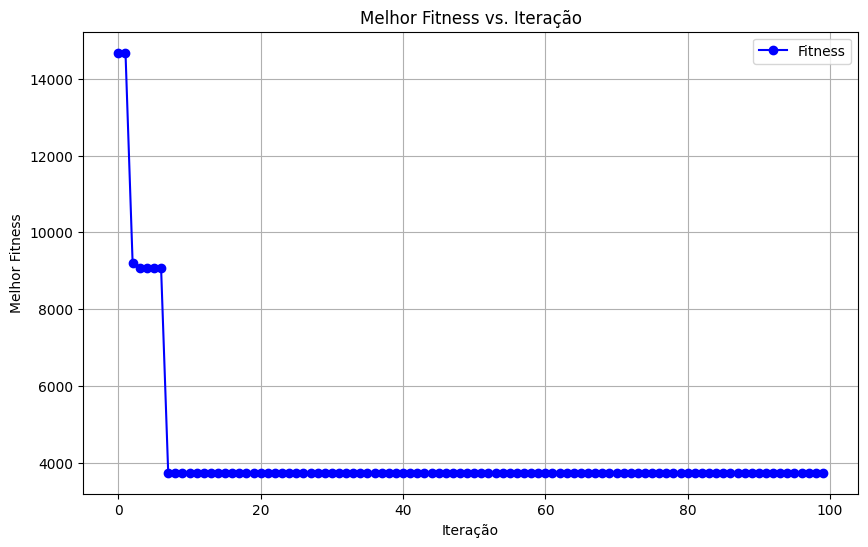

Iteração 100 | Melhor solução: [-11.33516573 -35.12026388 -31.08279179  14.38617566 -39.02545842
  15.22372923  12.82481648 -23.2571131  -90.53217086 -12.59123012] | Fitness: 13349.751513439236 | Histórico Fitness: [18694.222882566042, 18694.222882566042, 18694.222882566042, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 13349.751513439236, 1334

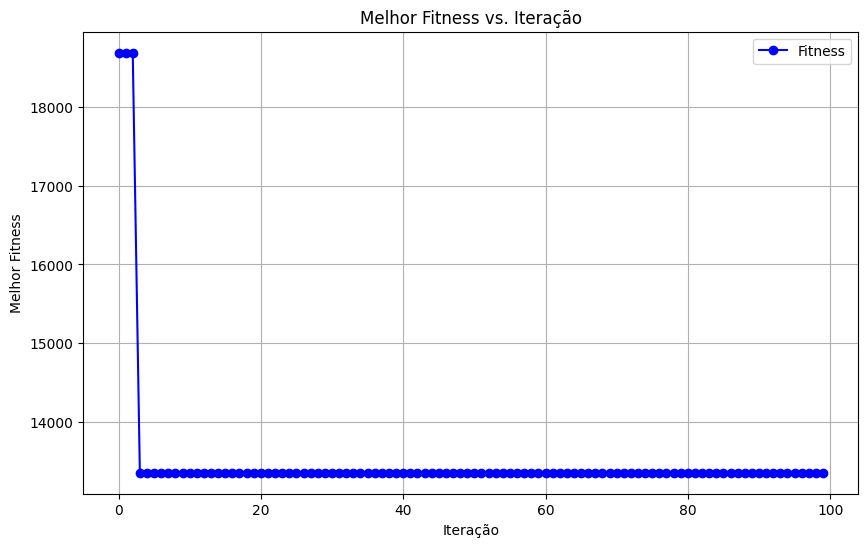

Iteração 100 | Melhor solução: [ 16.81656979  15.83036589  10.49912471   1.96819294  12.55552822
  51.40475917 -27.69721975  -4.73534727 -27.96640379  30.74653034] | Fitness: 5964.621825380018 | Histórico Fitness: [18746.402185290826, 12505.441614973493, 12505.441614973493, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 5964.621825380018, 596

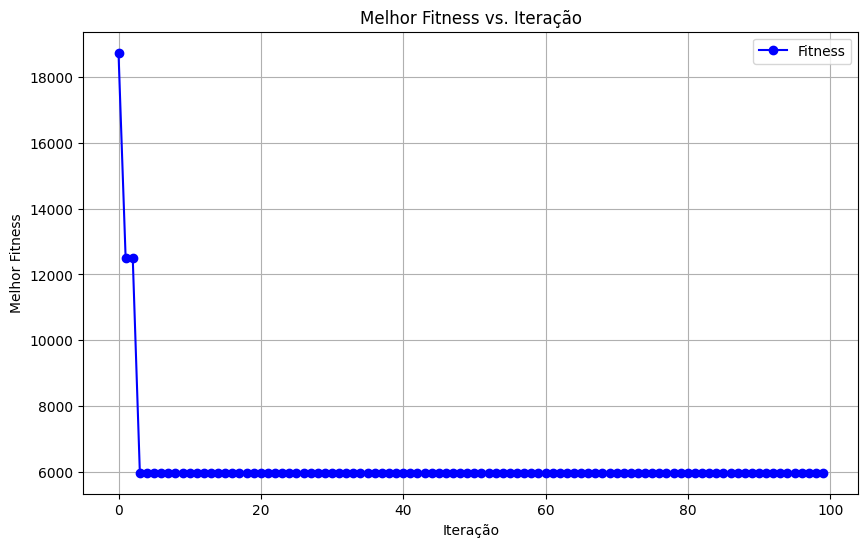

Iteração 100 | Melhor solução: [-46.4607862    6.21335935 -54.53771522  53.48033584  -9.89198653
  11.23255762  13.15074443  18.31224968 -27.85540611   3.85583546] | Fitness: 9554.81262341798 | Histórico Fitness: [11411.072505559752, 9696.828181684865, 9696.828181684865, 9696.828181684865, 9696.828181684865, 9696.828181684865, 9696.828181684865, 9696.828181684865, 9696.828181684865, 9696.828181684865, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9554.81262341798, 9

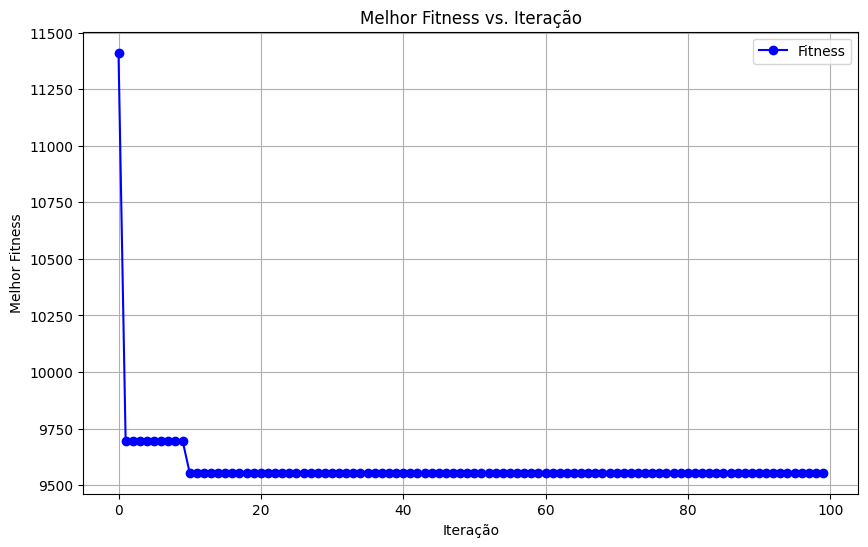

Iteração 100 | Melhor solução: [  4.48521012  -6.76607247  16.07151891  39.22181975   3.15602264
 -14.20165352  30.92899479 -17.81267532   3.54580749   2.8814718 ] | Fitness: 3368.9589040233586 | Histórico Fitness: [18112.974793167756, 11476.675991208594, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368.9589040233586, 3368

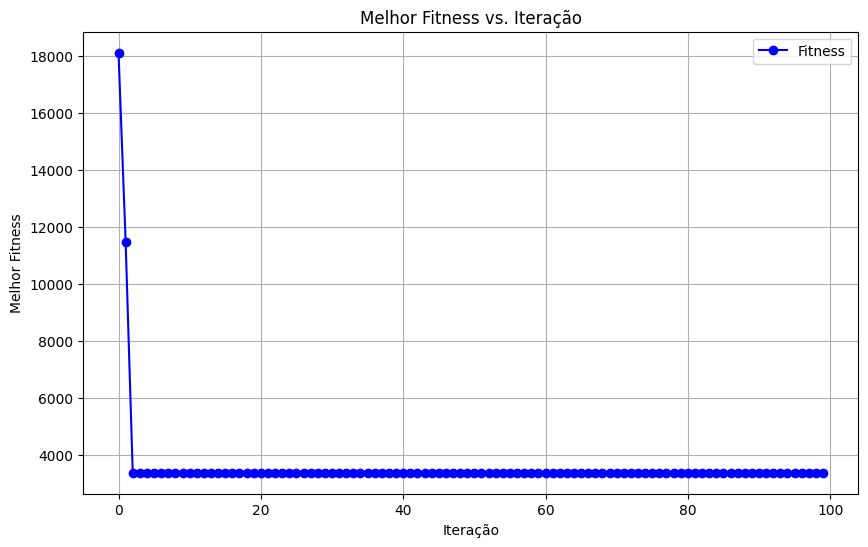

Iteração 100 | Melhor solução: [ 41.40881071 -10.37321947  21.32002066   5.47027545 -54.08065123
 -26.46205583  56.96748123   5.98679128 -12.45787326   3.5957559 ] | Fitness: 9380.981371468639 | Histórico Fitness: [13987.764953844995, 11211.456640002176, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380.981371468639, 9380

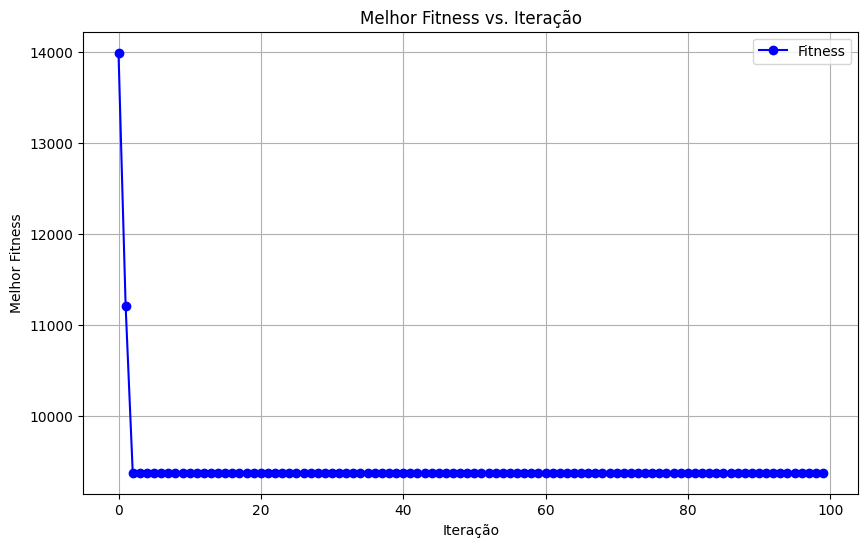

Iteração 100 | Melhor solução: [  1.44993289  24.479957   -32.8553363   -4.83024357  49.67343017
 -10.71070473 -30.9005726   -0.09010997   3.20607933 -29.43051045] | Fitness: 6117.631233822898 | Histórico Fitness: [14864.044545475877, 14864.044545475877, 14864.044545475877, 14864.044545475877, 14864.044545475877, 14864.044545475877, 14864.044545475877, 14864.044545475877, 14864.044545475877, 14864.044545475877, 6117.631233822898, 6117.631233822898, 6117.631233822898, 6117.631233822898, 6117.631233822898, 6117.631233822898, 6117.631233822898, 6117.631233822898, 6117.631233822898, 6117.631233822898, 6117.631233822898, 6117.631233822898, 6117.631233822898, 6117.631233822898, 6117.631233822898, 6117.631233822898, 6117.631233822898, 6117.631233822898, 6117.631233822898, 6117.631233822898, 6117.631233822898, 6117.631233822898, 6117.631233822898, 6117.631233822898, 6117.631233822898, 6117.631233822898, 6117.631233822898, 6117.631233822898, 6117.631233822898, 6117.631233822898, 6117.6312338228

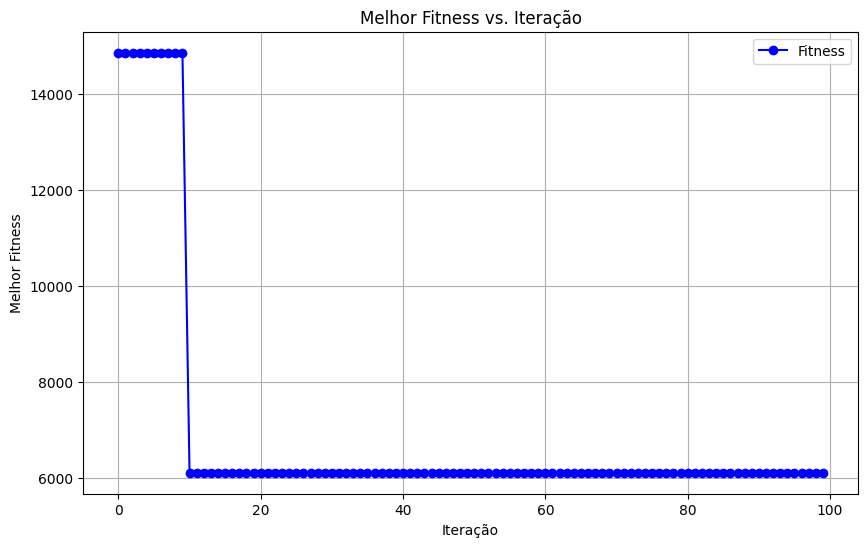

Iteração 100 | Melhor solução: [ -6.31411513  40.64262771  10.53733957   5.67662173 -23.406826
   5.10923082 -53.24844456 -12.73100305   4.51612189   0.73788072] | Fitness: 5427.349650827216 | Histórico Fitness: [9916.502924934857, 9916.502924934857, 9916.502924934857, 9916.502924934857, 9916.502924934857, 9916.502924934857, 9916.502924934857, 9916.502924934857, 9916.502924934857, 9916.502924934857, 9916.502924934857, 9916.502924934857, 9916.502924934857, 9916.502924934857, 5427.349650827216, 5427.349650827216, 5427.349650827216, 5427.349650827216, 5427.349650827216, 5427.349650827216, 5427.349650827216, 5427.349650827216, 5427.349650827216, 5427.349650827216, 5427.349650827216, 5427.349650827216, 5427.349650827216, 5427.349650827216, 5427.349650827216, 5427.349650827216, 5427.349650827216, 5427.349650827216, 5427.349650827216, 5427.349650827216, 5427.349650827216, 5427.349650827216, 5427.349650827216, 5427.349650827216, 5427.349650827216, 5427.349650827216, 5427.349650827216, 5427.349

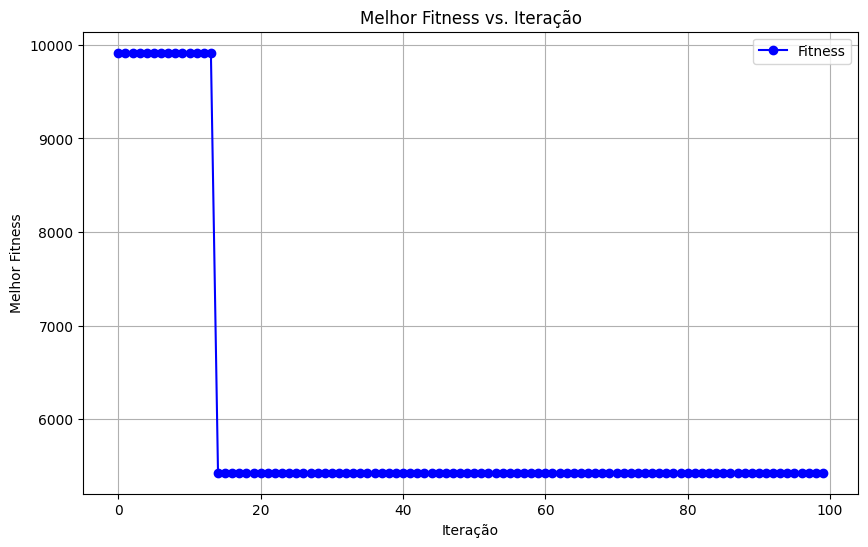

Iteração 100 | Melhor solução: [ 94.71810541   7.65967328 -11.28943209  -8.90223437 -45.35835222
  84.46997578  -2.1424497   -6.91205165  -5.8801631   -7.91685969] | Fitness: 18579.067599421873 | Histórico Fitness: [18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 18579.067599421873, 1857

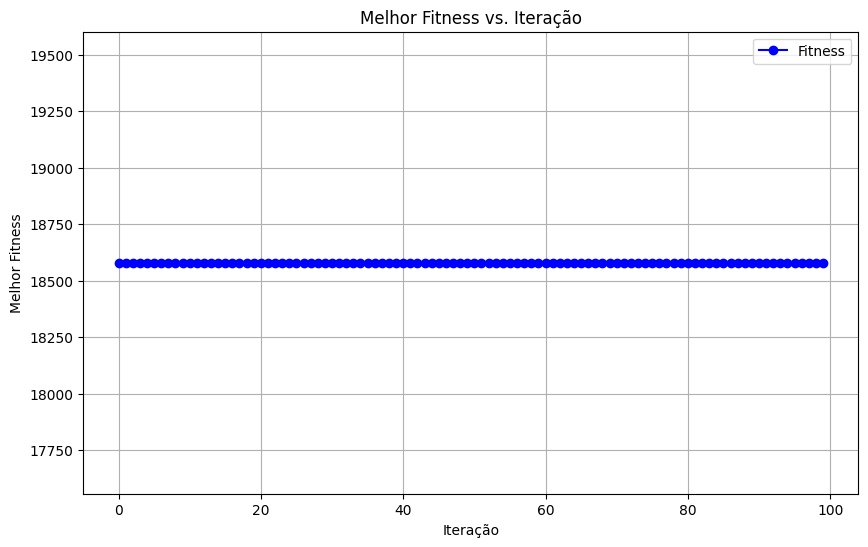

Iteração 100 | Melhor solução: [-44.45001544 -24.32324981 -59.12305979  -5.84856687  16.43392289
  48.98672271   3.20162164 -48.58389735   7.19837373  34.09723661] | Fitness: 12352.022702786595 | Histórico Fitness: [12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 12352.022702786595, 1235

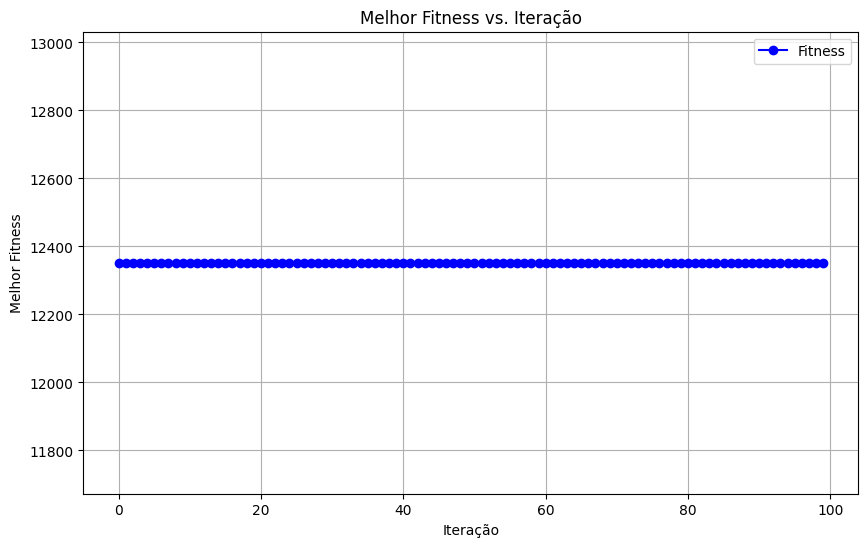

In [6]:
pso0 = AlgoritmoEnxameParticulas(sphere, [-100, 100], [-1, 1], [-100, 100], Inercia.CONSTANTE, Cooperacao.LOCAL_SOCIAL, 5)
pso0.otimizar()
pso0.plotar_grafico_convergencia()

pso1 = AlgoritmoEnxameParticulas(sphere, [-100, 100], [-5, 5], [-100, 100], Inercia.CONSTANTE, Cooperacao.LOCAL_SOCIAL, 5)
pso1.otimizar()
pso1.plotar_grafico_convergencia()

pso2 = AlgoritmoEnxameParticulas(sphere, [-100, 100], [-10, 10], [-100, 100], Inercia.CONSTANTE, Cooperacao.LOCAL_SOCIAL, 5)
pso2.otimizar()
pso2.plotar_grafico_convergencia()

pso3 = AlgoritmoEnxameParticulas(sphere, [-100, 100], [-30, 30], [-100, 100], Inercia.CONSTANTE, Cooperacao.LOCAL_SOCIAL, 5)
pso3.otimizar()
pso3.plotar_grafico_convergencia()

pso4 = AlgoritmoEnxameParticulas(sphere, [-100, 100], [-50, 50], [-100, 100], Inercia.CONSTANTE, Cooperacao.LOCAL_SOCIAL, 5)
pso4.otimizar()
pso4.plotar_grafico_convergencia()

pso5 = AlgoritmoEnxameParticulas(sphere, [-100, 100], [-70, 70], [-100, 100], Inercia.CONSTANTE, Cooperacao.LOCAL_SOCIAL, 5)
pso5.otimizar()
pso5.plotar_grafico_convergencia()

pso6 = AlgoritmoEnxameParticulas(sphere, [-100, 100], [-100, 100], [-100, 100], Inercia.CONSTANTE, Cooperacao.LOCAL_SOCIAL, 5)
pso6.otimizar()
pso6.plotar_grafico_convergencia()

pso7 = AlgoritmoEnxameParticulas(sphere, [-100, 100], [-150, 150], [-100, 100], Inercia.CONSTANTE, Cooperacao.LOCAL_SOCIAL, 5)
pso7.otimizar()
pso7.plotar_grafico_convergencia()

pso8 = AlgoritmoEnxameParticulas(sphere, [-100, 100], [-200, 200], [-100, 100], Inercia.CONSTANTE, Cooperacao.LOCAL_SOCIAL, 5)
pso8.otimizar()
pso8.plotar_grafico_convergencia()

pso9 = AlgoritmoEnxameParticulas(sphere, [-100, 100], [-500, 500], [-100, 100], Inercia.CONSTANTE, Cooperacao.LOCAL_SOCIAL, 5)
pso9.otimizar()
pso9.plotar_grafico_convergencia()

C:\Users\Pedro\AppData\Local\Temp\ipykernel_20604\3373224042.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(dados, labels=['Cenário 1', 'Cenário 2', 'Cenário 3', 'Cenário 4', 'Cenário 5'])


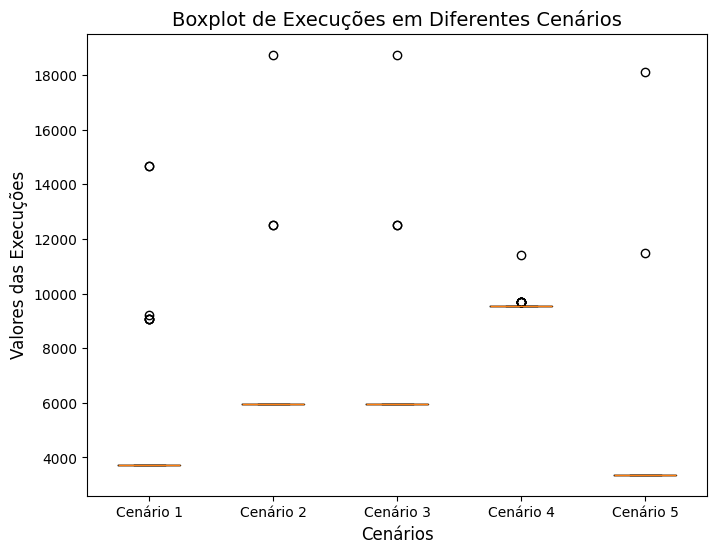

In [7]:
cenario_1 = pso0.melhores_fitness
cenario_2 = pso2.melhores_fitness
cenario_3 = pso2.melhores_fitness
cenario_4 = pso3.melhores_fitness
cenario_5 = pso4.melhores_fitness

dados = [cenario_1, cenario_2, cenario_3, cenario_4, cenario_5]

# Criando o boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(dados, labels=['Cenário 1', 'Cenário 2', 'Cenário 3', 'Cenário 4', 'Cenário 5'])

# Adicionando título e rótulos aos eixos
plt.title('Boxplot de Execuções em Diferentes Cenários', fontsize=14)
plt.xlabel('Cenários', fontsize=12)
plt.ylabel('Valores das Execuções', fontsize=12)

# Mostrando o gráfico
plt.show()

C:\Users\Pedro\AppData\Local\Temp\ipykernel_20604\692354162.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(dados, labels=['Cenário 1', 'Cenário 2', 'Cenário 3', 'Cenário 4', 'Cenário 5'])


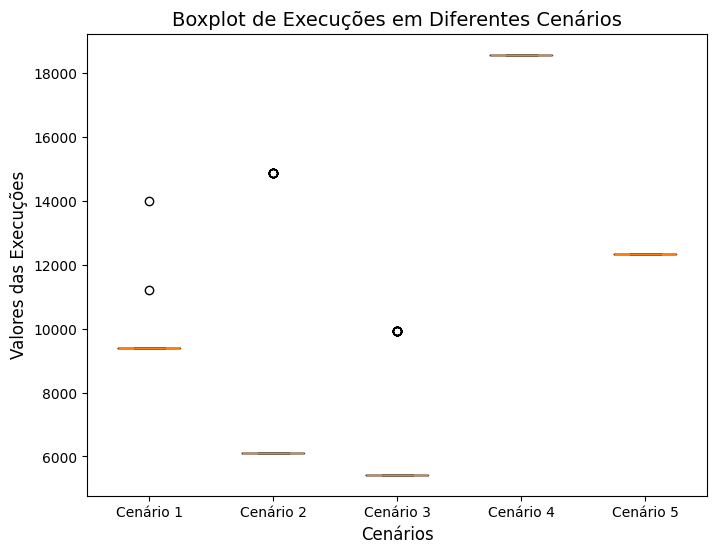

In [8]:
cenario_1 = pso5.melhores_fitness
cenario_2 = pso6.melhores_fitness
cenario_3 = pso7.melhores_fitness
cenario_4 = pso8.melhores_fitness
cenario_5 = pso9.melhores_fitness

dados = [cenario_1, cenario_2, cenario_3, cenario_4, cenario_5]

# Criando o boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(dados, labels=['Cenário 1', 'Cenário 2', 'Cenário 3', 'Cenário 4', 'Cenário 5'])

# Adicionando título e rótulos aos eixos
plt.title('Boxplot de Execuções em Diferentes Cenários', fontsize=14)
plt.xlabel('Cenários', fontsize=12)
plt.ylabel('Valores das Execuções', fontsize=12)

# Mostrando o gráfico
plt.show()

In [9]:
sphere([ 26.70864587, -46.24638104,  -2.6029387,   42.56514203,  41.91662183,
  27.02328694,   1.06964007, -16.55968044, -14.8926166,  -24.36136101])

8248.54043770519